<a href="https://colab.research.google.com/github/ling-lyanna-zhang/recourse-neural-policy/blob/main/800epochs_rld_118bus_(step3)eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# in case gpu is used
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


In [4]:
import os, time
import cvxpy as cp
import random
from numpy import savetxt
import argparse
import json
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np

from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
from torch.autograd import Variable
import torch.distributions.multivariate_normal as tdm

root_path = './gdrive/MyDrive/Inbox/rld_neural_policy/'

# helper functions, can be folded

## utils.py

In [5]:
def create_dir(PATH):
    isExist = os.path.exists(PATH)

    if not isExist:
        # Create a new directory if it does not exist 
        os.makedirs(PATH)
        print("The new directory is created!")


# Evaluate using vector distance
def measure_relative_distance(v1, v2):
    '''
        Note that v1 is the benchmark.
        Norm is calculated along dimension/axis 1
        and average is calculated along dimension/axis 0
        Also return the distance vetor.
    '''
    if len(v1.shape)==1 and len(v2.shape)==1:
        distance = np.abs(v1-v2)/np.abs(v1)

    if len(v1.shape)==2 and len(v2.shape)==2:
        distance = np.linalg.norm(v1-v2, axis=1)/np.linalg.norm(v1, axis=1)

    return distance, np.mean(distance)

## paths.py




In [6]:
def get_paths():
    params_path = root_path+'118bus/params/'
    data_path = root_path+'118bus/data/'
    model_path = root_path+'118bus/saved_models/'
    saved_path = root_path+'118bus/predictions/'

    return params_path, data_path, saved_path, model_path

In [7]:
def load_cost_coeff(params_path):    
    quad_cost_coeff = np.load(params_path+'quad_cost_coeff.npy')
    linear_cost_coeff = np.load(params_path+'linear_cost_coeff.npy')
    da_cost_coeff = np.load(params_path+'da_cost_coeff.npy')

    return quad_cost_coeff, linear_cost_coeff, da_cost_coeff

## system.py

In [8]:
def identify_unique_lines(connections):
    all_lines = {}
    count = 0
    for line in connections:
        all_lines[count] = line
        count+=1

    # This code snippet only finds out the repeated lines with exactly the same order of nodes,
    # but not deal with that [i,j] and [j,i] are also repeated lines
    # By checking connections, there is no repeated lines like [i,j] and [j,i]
    unique_lines = {}
    for k, val in all_lines.items():
        if val not in unique_lines.values():
            unique_lines[k]=val
    print('unique_lines length:', len(unique_lines))

    repeated_lines = [[42, 49],[49, 54],[56, 59],[49, 66],[77, 80],[89, 90],[89, 92]]
    # For example, [42, 49] appears twice
    set1 = {}
    set2 = {}
    for k, val in all_lines.items():
        if val in repeated_lines and k in unique_lines:
            set1[val[0], val[1]] = k # Record the repeated lines when they first appear
        if val in repeated_lines and k not in unique_lines:
            set2[val[0], val[1]] = k # Record the repeated lines when they appear more than once

    # print('set1:', len(set1))
    # print('set2:', len(set2))

    return unique_lines, set1, set2


def get_Y(N, B):
    # N = num_buses
    Y = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            if i==j : 
                Y[i,j] = sum(B[i,:])
            else: 
                Y[i,j] = -B[i,j]

    return Y[:,1:]


def get_A(N, L, B, connections):
    # N = num_buses
    # L = num_lines 
    A = np.zeros((L, N))

    for i, line in enumerate(connections):
        row = line[0]-1
        col = line[1]-1
        A[i, row] = B[row,col]
        A[i, col] = -B[row,col]

    return A[:,1:]


# Import 118bus
def import_118bus(params_path):
    bus_data_fname = '118bus_BusData.csv'
    gen_data_fname = '118bus_GenData.csv'

    branch_data_fname = '118bus_BranchData.csv'
    cost_data_fname = '118bus_CostData.csv'

    bus_data_df = pd.read_csv(params_path+bus_data_fname,header=None)
    gen_data_df = pd.read_csv(params_path+gen_data_fname,header=None)
    branch_data_df = pd.read_csv(params_path+branch_data_fname,header=None)
    cost_data_df = pd.read_csv(params_path+cost_data_fname,header=None)


    num_buses = bus_data_df.shape[0]
    num_lines = branch_data_df.shape[0]
    num_gens = gen_data_df.shape[0]


    bus_data = bus_data_df.to_numpy()
    gen_data = gen_data_df.to_numpy()
    branch_data = branch_data_df.to_numpy()
    cost_data = cost_data_df.to_numpy()

    x = branch_data[:,3]
    print('max of x:', max(x))
    print('min of x:', min(x))


    b = 1/x
    Z0 = 10
    b = b/Z0
    print('max of b:', max(b))
    print('min of b:', min(b))

    connections = []
    branches = branch_data[:,:2]
    for i in range(branches.shape[0]):
            connections.append([int(branches[i,0]),int(branches[i,1])])
    print('len of connections:', len(connections))

    unique_lines, set1, set2 = identify_unique_lines(connections)

    B = np.zeros((num_buses, num_buses))
    for k, line in unique_lines.items():
        row = line[0]-1
        col = line[1]-1
        B[row, col] = b[k]
        B[col, row] = b[k]

    PD = bus_data[:,2]/20
    print('Total PD:', sum(PD))

    return num_buses, num_lines, B, connections, PD

### import B, F and cost

In [9]:
params_path, data_path, saved_path, model_path = get_paths()

num_buses, num_lines, B, connections, PD_data = import_118bus(params_path)

N = num_buses
L = num_lines 

Yrr = get_Y(num_buses, B)
Arr = get_A(num_buses, num_lines, B, connections)

# Define feasibility set for gauge mapping
G = np.block([
              [Arr],
              [-Arr],
              [np.eye(N-1)],
              [-np.eye(N-1)]
])
print('G shape:', G.shape)

# Load cost coefficients
quad_cost_coeff, linear_cost_coeff, da_cost_coeff = load_cost_coeff(params_path) 

quad_cost_Coeff = np.diag(quad_cost_coeff)
linear_cost_Coeff = linear_cost_coeff.reshape(-1, 1)
da_cost_Coeff = da_cost_coeff.reshape(-1,1)

print('quad_cost_Coeff shape:', quad_cost_Coeff.shape)
print('linear_cost_Coeff shape:', linear_cost_Coeff.shape)
print('da_cost_Coeff shape:', da_cost_Coeff.shape)

max of x: 0.411
min of x: 0.004
max of b: 25.0
min of b: 0.24330900243309003
len of connections: 186
unique_lines length: 179
Total PD: 212.10000000000005
G shape: (606, 117)
quad_cost_Coeff shape: (118, 118)
linear_cost_Coeff shape: (118, 1)
da_cost_Coeff shape: (118, 1)


### set Fmax and std

In [10]:
Fmax = 1.5
input_std = 0.1
sce_std = 0.05

# load.py

In [11]:
nominal_PD_data = PD_data.reshape(1,-1)

# Load dataset
train_dataset = np.load(data_path+'train_set.npy')
test_dataset = np.load(data_path+'test_set.npy')
pretrain_dataset = np.load(data_path+'pretrain_set.npy')

Ntr = train_dataset.shape[0]
Ntr2 = pretrain_dataset.shape[0]
Ntst = test_dataset.shape[0]


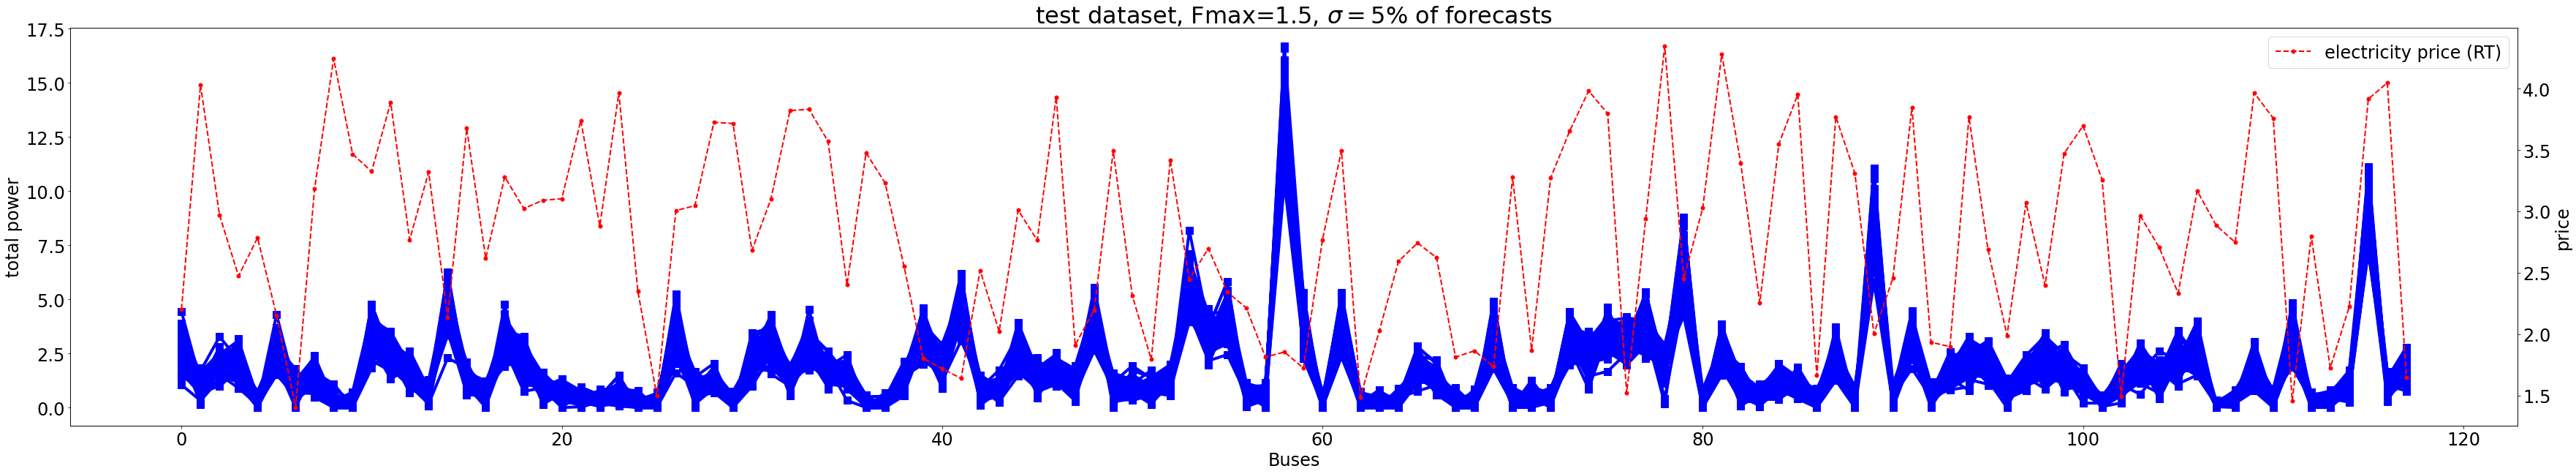

In [12]:
fig, ax0 = plt.subplots(figsize=(60,10))
Xrange = np.array(range(N))
N_points = Ntst
for i in range(N_points):
    ax0.plot(Xrange, test_dataset[i,:], 'b-s', markersize=10, linewidth=4)

# ax0.axhline(y=Pmax, xmin=0.0, xmax=1.0, color='k', linestyle='--', linewidth=1, label='Pmax')
# ax0.legend(fontsize=24)
ax0.tick_params(axis='x', labelsize=24 )
ax0.tick_params(axis='y', labelsize=24 )
ax0.set_xlabel('Buses', fontsize=24 )
ax0.set_ylabel('total power', fontsize=24 )
ax0.set_title(r'test dataset, Fmax='+str(Fmax)+', $\sigma=$'+str(int(sce_std*100))+'% of forecasts', 
              fontsize=32, color='k')

ax1 = ax0.twinx()
ax1.plot(range(N), linear_cost_coeff, 'r--o', markersize=5, linewidth=2, label='electricity price (RT)')
ax1.tick_params(axis='y', labelsize=24 )
ax1.set_ylabel('price', fontsize=24, rotation=90 )
ax1.legend(fontsize=24)


plt.show()

# eval.py


In [13]:
N_ap = 50
N_gap = 50
N_cp = 500
N_eval = 500

## Benchmark1: use cvxpy to solve saa version of the true problem

In [14]:
# Load solutions from cvxpy
x_cp = np.load(data_path+'x_cp.npy')
total_cost_cp = np.load(data_path+'total_cost_cp.npy')
Q_cp = np.load(data_path+'Q_cp.npy')
y_cp = np.load(data_path+'y_cp.npy')

## Benchmark2: apply affine policy to $\theta$

In [ ]:
# # Load solutions from cvxpy
# x_ap = np.load(data_path+'x_ap.npy')
# total_cost_ap = np.load(data_path+'total_cost_ap.npy')
# Q_ap = np.load(data_path+'Q_ap.npy')
# y_ap = np.load(data_path+'y_ap.npy')

## Benchmark3: apply affine policy to generation, i.e., $y_i=\alpha_i \sum_{\tilde{d}} + s_i$ and use $y$ to eliminate $\theta$

In [15]:
# Load solutions from cvxpy
x_gap = np.load(data_path+'x_gap.npy')
total_cost_gap = np.load(data_path+'total_cost_gap.npy')
Q_gap = np.load(data_path+'Q_gap.npy')
y_gap = np.load(data_path+'y_gap.npy')

## Proposed neural policy

In [16]:
# Load solutions from cvxpy
x_nu = np.load(saved_path+'x_nu.npy')
total_cost_nu = np.load(saved_path+'total_cost_nu.npy')
Q_nu = np.load(saved_path+'Q_nu.npy')
y_nu = np.load(saved_path+'y_nu.npy')

## comparison

In [17]:
_, x_dist = measure_relative_distance(x_cp, x_nu)
total_cost_dist_vec, total_cost_dist = measure_relative_distance(total_cost_cp, total_cost_nu)
_, Q_dist = measure_relative_distance(Q_cp, Q_nu)
_, y_dist = measure_relative_distance(y_cp, y_nu)

print('Averaged relative error in x is %.2f%%' % (x_dist*100))
print('Averaged relative error in J is %.2f%%' % (total_cost_dist*100))
print('Averaged relative error in Q is %.2f%%' % (Q_dist*100))
print('Averaged relative error in y is %.2f%%' % (y_dist*100))

Averaged relative error in x is 13.85%
Averaged relative error in J is 1.49%
Averaged relative error in Q is 117.32%
Averaged relative error in y is 183.01%


In [18]:
# _, x_dist2 = measure_relative_distance(x_cp, x_ap)
# total_cost_dist2_vec, total_cost_dist2 = measure_relative_distance(total_cost_cp, total_cost_ap)
# _, Q_dist2 = measure_relative_distance(Q_cp, Q_ap)
# _, y_dist2 = measure_relative_distance(y_cp, y_ap)

# print('Averaged relative error in x is %.2f%%' % (x_dist2*100))
# print('Averaged relative error in J is %.2f%%' % (total_cost_dist2*100))
# print('Averaged relative error in Q is %.2f%%' % (Q_dist2*100))
# print('Averaged relative error in y is %.2f%%' % (y_dist2*100))

In [19]:
_, x_dist3 = measure_relative_distance(x_cp, x_gap)
total_cost_dist3_vec, total_cost_dist3 = measure_relative_distance(total_cost_cp, total_cost_gap)
_, Q_dist3 = measure_relative_distance(Q_cp, Q_gap)
_, y_dist3 = measure_relative_distance(y_cp, y_gap)

print('Averaged relative error in x is %.2f%%' % (x_dist3*100))
print('Averaged relative error in J is %.2f%%' % (total_cost_dist3*100))
print('Averaged relative error in Q is %.2f%%' % (Q_dist3*100))
print('Averaged relative error in y is %.2f%%' % (y_dist3*100))

Averaged relative error in x is 22.75%
Averaged relative error in J is 2.91%
Averaged relative error in Q is 27.53%
Averaged relative error in y is 287.05%


# Plotting

## total cost

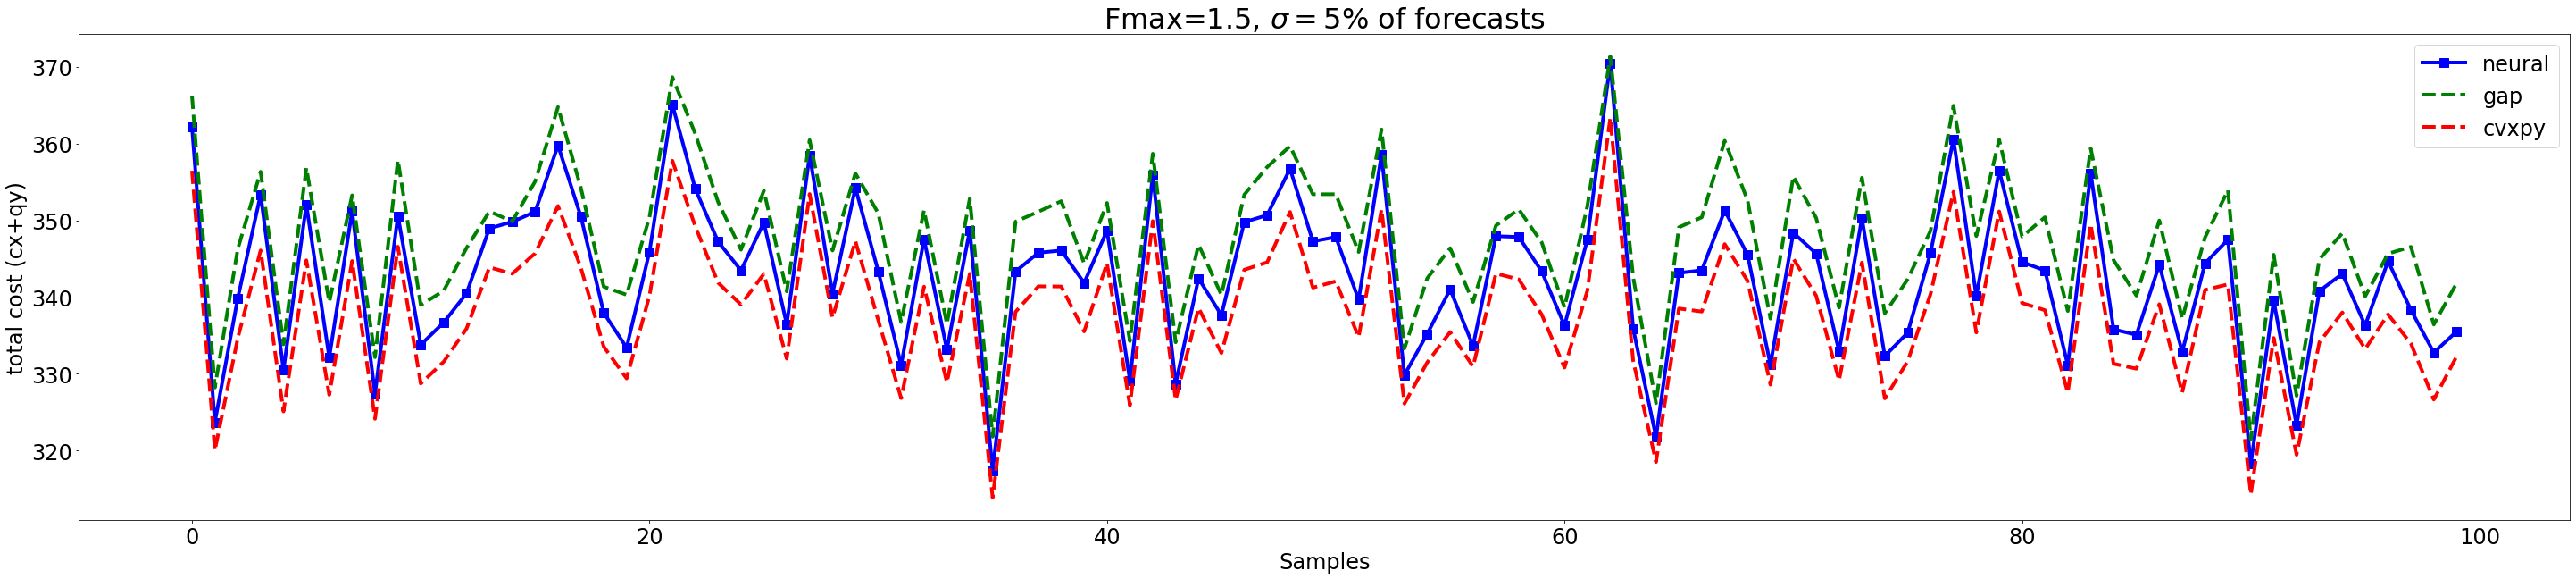

In [20]:
fig = plt.figure(figsize=(50,10))
Xrange = np.array(range(Ntst))
# N_points = Ntst
plt.plot(Xrange, total_cost_nu.flatten(), 'b-s', markersize=10, linewidth=4, label='neural')
# plt.plot(Xrange, total_cost_ap.flatten(), 'y-D', markersize=10, linewidth=4, label='ap')
plt.plot(Xrange, total_cost_gap.flatten(), 'g--', markersize=10, linewidth=4, label='gap')
plt.plot(Xrange, total_cost_cp.flatten(), 'r--', markersize=10, linewidth=4, label='cvxpy')

plt.legend(fontsize=24)
plt.xlabel('Samples', fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.ylabel('total cost (cx+qy)', fontsize=24)

plt.title(r'Fmax='+str(Fmax)+', $\sigma=$'+str(int(sce_std*100))+'% of forecasts', 
              fontsize=32, color='k')

plt.show()

## total power

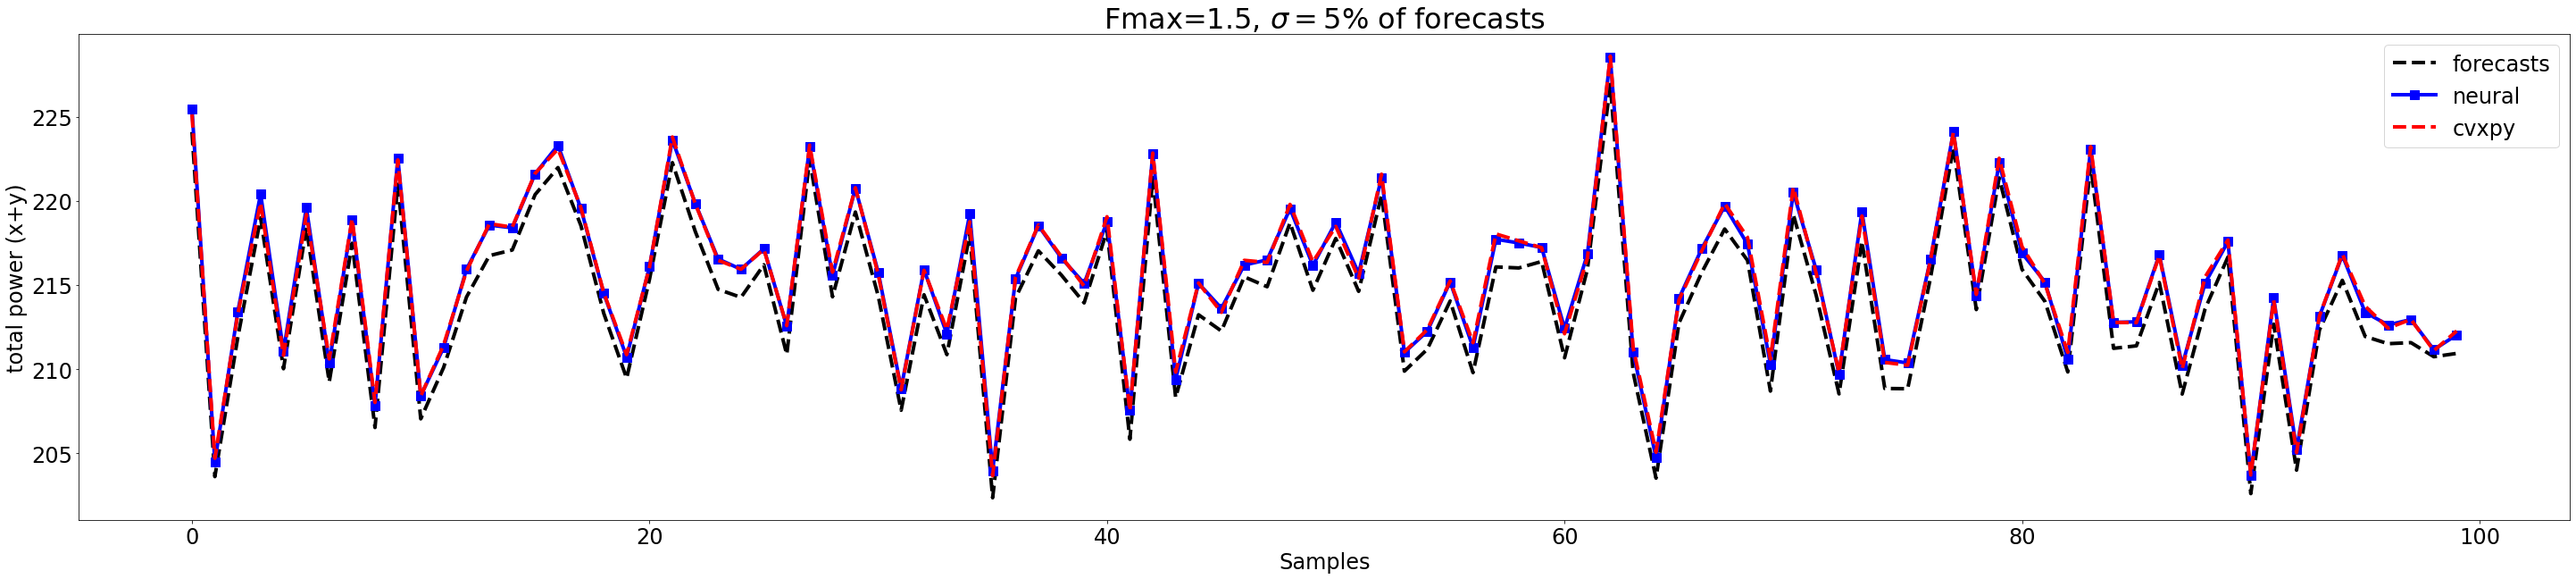

In [21]:
z_cp = x_cp + y_cp
z_nu = x_nu + y_nu
# z_ap = x_ap + y_ap
z_gap = x_gap + y_gap

fig = plt.figure(figsize=(50,10))
Xrange = np.array(range(Ntst))
plt.plot(Xrange, np.sum(test_dataset, axis=-1), color='black', 
         linestyle ='--',markersize=10, linewidth=4, label='forecasts')
plt.plot(Xrange, np.sum(z_nu, axis=-1), 'b-s', markersize=10, linewidth=4, label='neural')
# plt.plot(Xrange, np.sum(z_ap, axis=-1), 'y-D', markersize=10, linewidth=4, label='ap')
plt.plot(Xrange, np.sum(z_cp, axis=-1), 'r--', markersize=10, linewidth=4, label='cvxpy')
plt.legend(fontsize=24)
plt.xlabel('Samples', fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.ylabel('total power (x+y)', fontsize=24)
plt.title(r'Fmax='+str(Fmax)+', $\sigma=$'+str(int(sce_std*100))+'% of forecasts', 
              fontsize=32, color='k')

plt.show()

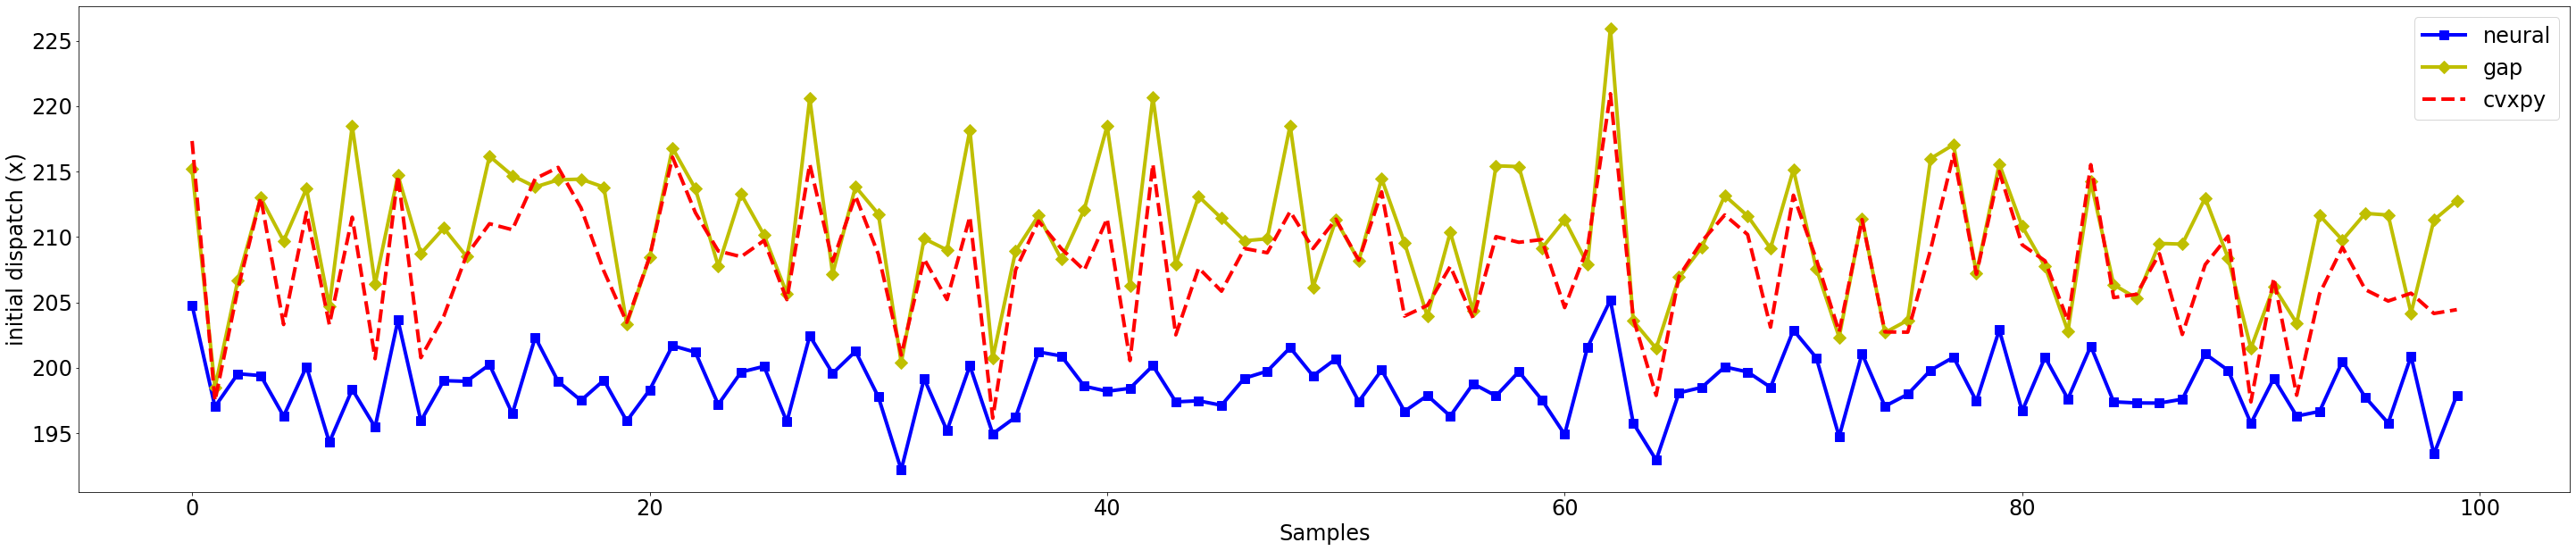

In [22]:
fig = plt.figure(figsize=(50,10))
Xrange = np.array(range(Ntst))
plt.plot(Xrange, np.sum(x_nu, axis=-1), 'b-s', markersize=10, linewidth=4, label='neural')
# plt.plot(Xrange, np.sum(x_ap, axis=-1), 'y-D', markersize=10, linewidth=4, label='ap')
plt.plot(Xrange, np.sum(x_gap, axis=-1), 'y-D', markersize=10, linewidth=4, label='gap')
plt.plot(Xrange, np.sum(x_cp, axis=-1), 'r--', markersize=10, linewidth=4, label='cvxpy')
plt.legend(fontsize=24)
plt.xlabel('Samples', fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.ylabel('initial dispatch (x)', fontsize=24)

plt.show()

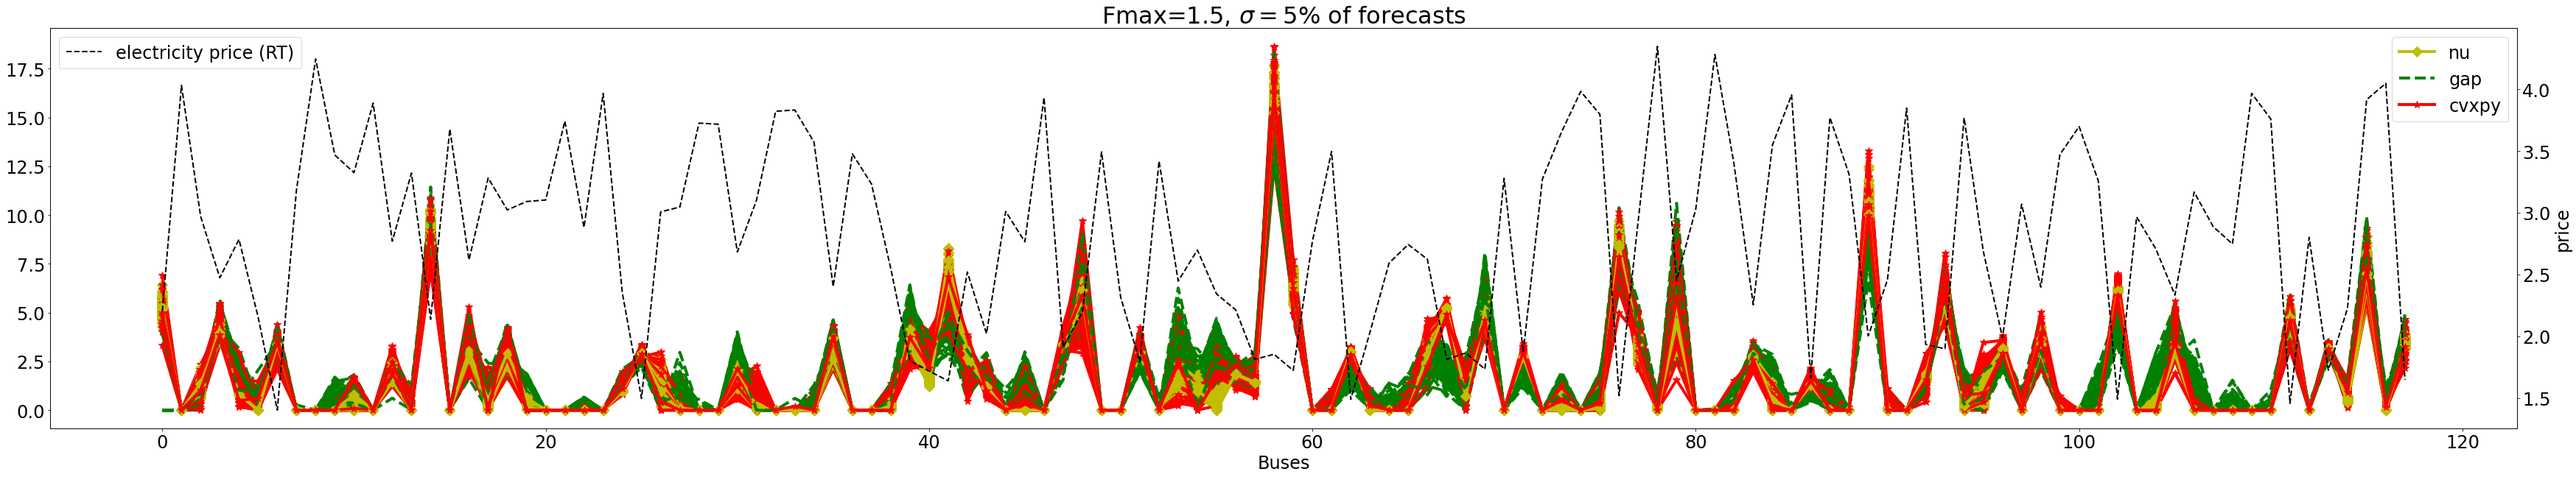

In [23]:
fig, ax0 = plt.subplots(figsize=(60,10))
Xrange = np.array(range(N))
N_points = Ntst
for i in range(N_points):
    if i == 0:
        ax0.plot(Xrange, x_nu[i,:], 'y-D', markersize=10, linewidth=4, label='nu')
        ax0.plot(Xrange, x_gap[i,:], 'g--', markersize=10, linewidth=4, label='gap')
        ax0.plot(Xrange, x_cp[i,:], 'r-*', markersize=10, linewidth=4, label='cvxpy')

    else:
        ax0.plot(Xrange, x_nu[i,:], 'y-D', markersize=10, linewidth=4)
        ax0.plot(Xrange, x_gap[i,:], 'g--', markersize=10, linewidth=4)
        ax0.plot(Xrange, x_cp[i,:], 'r-*', markersize=10, linewidth=4)

# ax0.axhline(y=Pmax, xmin=0.0, xmax=1.0, color='k', linestyle='--', linewidth=1, label='Pmax')
ax0.legend(fontsize=24, loc='best')
ax0.tick_params(axis='x', labelsize=24 )
ax0.tick_params(axis='y', labelsize=24 )
ax0.set_xlabel('Buses', fontsize=24 )
# ax0.set_ylabel('total power', fontsize=24 )
ax0.set_title(r'Fmax='+str(Fmax)+', $\sigma=$'+str(int(sce_std*100))+'% of forecasts', 
              fontsize=32, color='k')

ax1 = ax0.twinx()
ax1.plot(range(N), linear_cost_coeff, 'k--', markersize=5, linewidth=2, label='electricity price (RT)')
ax1.tick_params(axis='y', labelsize=24 )
ax1.set_ylabel('price', fontsize=24, rotation=90 )
ax1.legend(fontsize=24, loc='upper left')


plt.show()

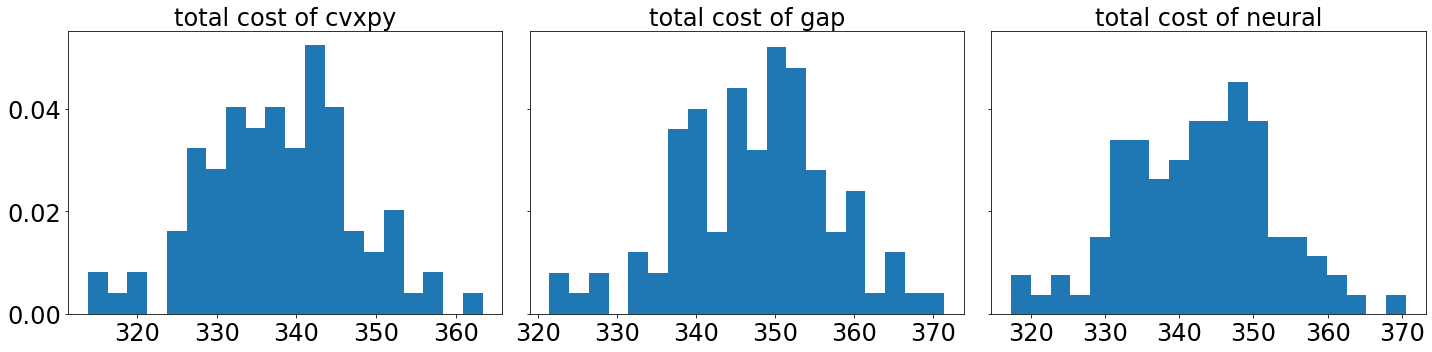

In [24]:
fig, axs = plt.subplots(1, 3, sharey=True,tight_layout=True, figsize=(20,5))

n_bins = 20
axs[0].hist(total_cost_cp.flatten(), bins=n_bins, density=True)

axs[0].tick_params(axis='x', labelsize=24 )
axs[0].tick_params(axis='y', labelsize=24 )
# ax0.set_xlabel('Buses', fontsize=24 )
# ax0.set_ylabel('total power', fontsize=24 )
axs[0].set_title(r'total cost of cvxpy', fontsize=24, color='k' )

axs[1].hist(total_cost_gap.flatten(), bins=n_bins, density=True)
axs[1].tick_params(axis='x', labelsize=24 )
axs[1].set_title(r'total cost of gap', fontsize=24, color='k' )

axs[2].hist(total_cost_nu.flatten(), bins=n_bins, density=True)
axs[2].tick_params(axis='x', labelsize=24 )
axs[2].set_title(r'total cost of neural', fontsize=24, color='k' )
plt.show()



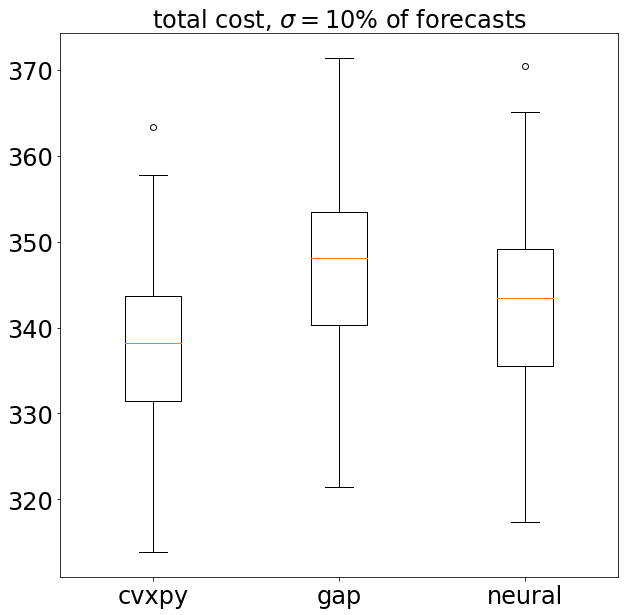

In [25]:
fig, ax0 = plt.subplots(figsize=(10,10))
Xrange = np.array(range(N))

n_bins = 20

data = [total_cost_cp.flatten(), total_cost_gap.flatten(), total_cost_nu.flatten()]
ax0.boxplot(data)

ax0.tick_params(axis='x', labelsize=24 )
ax0.tick_params(axis='y', labelsize=24 )
# ax0.set_xlabel('Buses', fontsize=24 )
# ax0.set_ylabel('total power', fontsize=24 )
ax0.set_xticklabels(['cvxpy', 'gap', 'neural'])

ax0.set_title(r'total cost, $\sigma=$'+str(int(input_std*100))+'% of forecasts', fontsize=24, color='k' )
plt.show()
